In [1]:
import os
from sklearn.model_selection import train_test_split
# from IPython.display import Image

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from bs4 import BeautifulSoup

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
img_path = 'drive/MyDrive/ColabNotebooks/archive/images/'
ann_path = 'drive/MyDrive/ColabNotebooks/archive/annotations/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_transforms = transforms.Compose([
        transforms.ToTensor(),
])

In [4]:
imgs = list(sorted(os.listdir(img_path)))
train_ims, test_ims = train_test_split(imgs)
print(len(train_ims), len(test_ims))

640 214


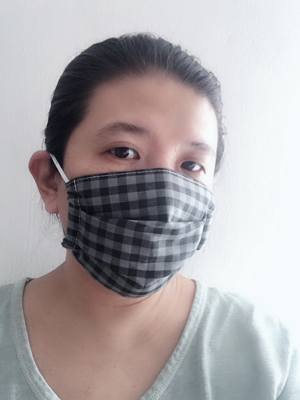

In [5]:
Image.open('drive/MyDrive/ColabNotebooks/archive/images/{}'.format(train_ims[0]))

In [6]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    elif obj.find('name').text == "without_mask":
        return 3
    else:
        return 0

In [7]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_dir, image_list, transforms):
        self.transforms = transforms
        self.imgs = image_list
        
        self.img_dir, self.ann_dir = img_dir, ann_dir

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        
        img_path = os.path.join(self.img_dir, file_image)
        label_path = os.path.join(self.ann_dir, file_label)
        
        img = Image.open(img_path).convert("RGB")
        target = self.__generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)
        # TODO: return the length of the dataset
    @staticmethod
    def __generate_target(image_id, file): 
        with open(file) as f:
            data = f.read()
            soup = BeautifulSoup(data, 'xml')
            objects = soup.find_all('object')

            # get bounding box coordinates for each mask
            boxes = []
            labels = []
            ###
            for each_object in objects:
                boxes.append(generate_box(each_object))
                labels.append(generate_label(each_object))
            ###
            ###################################################################
            # TODO: for each image, get the bounding box coordinates and labels
            # boxes and labels are lists
            # boxes: [[xmin, ymin, xmax, ymax], ...]
            # labels: [label, ...] 
            # label: 1 for with_mask, 2 for mask_weared_incorrect, 3 for without_mask
            ###################################################################
            pass

            ###################################################################

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            img_id = torch.tensor([image_id])

            # Annotation is in dictionary format
            ###
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = img_id
            
            print(target)
            ###
            ###################################################################
            # TODO: for each image, create a dictionary with the following keys
            # "boxes", "labels", "image_id"
            # "boxes": bounding box coordinates
            # "labels": labels
            # "image_id": image id
            # target is a dictionary
            # You should close look at the documentation of the model
            # https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
            # Faster RCNN model takes in a list of bounding boxes and the corresponding labels
            ###################################################################
            pass
            
            ###################################################################
            return target

def collate_fn(batch) : return tuple(zip(*batch))

In [8]:
# DataLoader 확인

train_data = MaskDataset(img_path, ann_path, train_ims, transforms=data_transforms)
train_data = DataLoader(train_data, batch_size = 1, shuffle = True,collate_fn = collate_fn)

for i, (img, target) in enumerate(train_data):
    print(img[0].shape)
    print(target)
    break

{'boxes': tensor([[ 42., 109.,  66., 140.],
        [  2., 105.,  22., 125.],
        [ 30.,  88.,  46., 105.],
        [133., 108., 174., 152.],
        [221., 101., 256., 139.],
        [304., 131., 331., 158.],
        [ 83.,  85.,  96.,  96.],
        [167.,  91., 180., 108.]]), 'labels': tensor([3, 3, 3, 1, 1, 3, 3, 3]), 'image_id': tensor([104])}
torch.Size([3, 267, 400])
({'boxes': tensor([[ 42., 109.,  66., 140.],
        [  2., 105.,  22., 125.],
        [ 30.,  88.,  46., 105.],
        [133., 108., 174., 152.],
        [221., 101., 256., 139.],
        [304., 131., 331., 158.],
        [ 83.,  85.,  96.,  96.],
        [167.,  91., 180., 108.]]), 'labels': tensor([3, 3, 3, 1, 1, 3, 3, 3]), 'image_id': tensor([104])},)


In [9]:
train_dataset = MaskDataset(img_path, ann_path, train_ims, transforms=data_transforms)    
val_dataset = MaskDataset(img_path, ann_path, test_ims, transforms=data_transforms)

###################################################################
# If you are struggling with memory, you can reduce the batch size (e.g. 1 or 2)
# (with batch size 4, you need at least 24GB of GPU memory)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
###################################################################

# For validation, batch size is always 1 because we want to see the result of each image
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [10]:
def get_model_instance_segmentation(num_classes, pretrained=True):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

###################################################################
num_classes = 4  
# Question 1: Why the number of classes is 4?
# Anwer: 3 classes(with_mask, mask_weared_incorrect, without_mask) + 1 background
###################################################################

model = get_model_instance_segmentation(num_classes).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
###################################################################
# If your computer is slow, you can reduce the number of epochs (e.g. 1 or 2)
# (It took 1 minutes per epoch on RTX 4090)
num_epochs = 3
###################################################################
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


In [12]:
def train_fn():
    model.train()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        progress = tqdm(enumerate(train_dataloader))
        total_loss = 0.0
        for i, (images, targets) in progress:
            if i == 200:
                break

            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # print(images, targets)
            optimizer.zero_grad()

            losses = model(images, targets)
            loss = sum(loss for loss in losses.values())

            progress.set_description(f"{epoch}, {i}, C: {losses['loss_classifier'].item():.5f}, B: {losses['loss_box_reg'].item():.5f}, O: {losses['loss_objectness'].item():.5f}, T: {loss.item():.5f}")
            print(
                f"{epoch}, {i}, C: {losses['loss_classifier'].item():.5f},  "
                f"B: {losses['loss_box_reg'].item():.5f}, O: {losses['loss_objectness'].item():.5f}, T: {loss.item():.5f}")
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        lr_scheduler.step()
        print(f"Epoch {epoch + 1} Total loss: {total_loss / len(train_dataloader)}")

        torch.save(model.state_dict(), 'checkpoint.pt')

In [13]:
train_fn()

Epoch 1/3


0it [00:00, ?it/s]

{'boxes': tensor([[ 78., 176., 178., 304.]]), 'labels': tensor([1]), 'image_id': tensor([60])}
{'boxes': tensor([[170.,  43., 195.,  69.],
        [ 36.,  99.,  54., 114.],
        [234., 153., 258., 186.],
        [383., 127., 400., 150.],
        [220.,  86., 230., 102.]]), 'labels': tensor([1, 3, 3, 3, 3]), 'image_id': tensor([575])}
0, 0, C: 1.86517,  B: 0.08866, O: 0.24869, T: 2.23413
{'boxes': tensor([[ 18.,  84.,  64., 134.],
        [ 18., 200.,  69., 246.],
        [112.,  46., 149.,  73.],
        [237., 137., 290., 186.],
        [278.,  17., 322.,  66.],
        [342.,  98., 385., 140.],
        [346., 218., 393., 254.]]), 'labels': tensor([3, 3, 3, 1, 3, 3, 3]), 'image_id': tensor([327])}
{'boxes': tensor([[148.,  75., 201., 133.],
        [ 27.,  78.,  56., 106.]]), 'labels': tensor([2, 3]), 'image_id': tensor([9])}
0, 1, C: 0.86031,  B: 0.15996, O: 0.25903, T: 1.31773
{'boxes': tensor([[ 68., 213., 144., 306.]]), 'labels': tensor([1]), 'image_id': tensor([259])}
{'boxes'

0it [00:00, ?it/s]

{'boxes': tensor([[  2.,  28.,  19.,  46.],
        [ 23.,  36.,  45.,  59.],
        [ 30.,  71.,  51.,  92.],
        [  4., 177.,  35., 209.],
        [ 93.,  15., 117.,  34.],
        [ 99.,  74., 122., 100.],
        [ 56., 132.,  79., 162.],
        [ 36., 152.,  65., 183.],
        [138., 191., 165., 221.],
        [182.,  13., 209.,  36.],
        [188.,  55., 213.,  80.],
        [196., 146., 219., 168.],
        [213., 164., 243., 193.],
        [253.,  13., 277.,  35.],
        [246.,  73., 268.,  98.],
        [286.,  10., 314.,  38.],
        [320.,   1., 341.,  15.],
        [345.,  34., 372.,  57.],
        [358., 116., 388., 141.]]), 'labels': tensor([1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([139])}
{'boxes': tensor([[138.,  79., 176., 116.],
        [217.,  70., 255., 107.]]), 'labels': tensor([1, 1]), 'image_id': tensor([118])}
1, 0, C: 0.09800,  B: 0.23655, O: 0.00243, T: 0.34749
{'boxes': tensor([[158.,  63., 189.,  99.],
       

0it [00:00, ?it/s]

{'boxes': tensor([[ 12., 141.,  39., 174.],
        [116., 115., 148., 151.],
        [179.,  79., 249., 149.],
        [323.,  95., 359., 143.],
        [ 87., 123., 108., 147.],
        [ 16., 115.,  38., 139.],
        [249., 122., 264., 141.],
        [356., 117., 370., 143.]]), 'labels': tensor([1, 1, 1, 1, 1, 3, 1, 1]), 'image_id': tensor([92])}
{'boxes': tensor([[  7., 215.,  50., 256.],
        [ 64., 190.,  92., 219.],
        [ 96., 161., 148., 220.],
        [183., 137., 214., 179.],
        [120.,  53., 138.,  72.],
        [153.,  22., 168.,  37.],
        [163.,  55., 177.,  73.],
        [194.,  31., 206.,  42.],
        [230.,  32., 245.,  48.],
        [219.,  88., 234., 105.],
        [257., 124., 298., 165.],
        [296.,  43., 310.,  57.],
        [332.,  81., 347.,  96.],
        [259.,  44., 274.,  60.],
        [170., 108., 189., 127.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3]), 'image_id': tensor([559])}
2, 0, C: 0.16409,  B: 0.30448, O

{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([3, 1, 3]), 'image_id': tensor([0])}


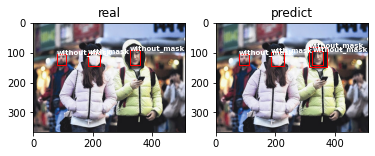

{'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 3]), 'image_id': tensor([1])}


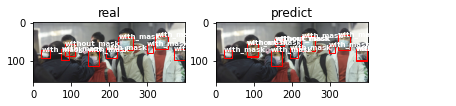

{'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]]), 'labels': tensor([1, 1, 1, 2]), 'image_id': tensor([2])}


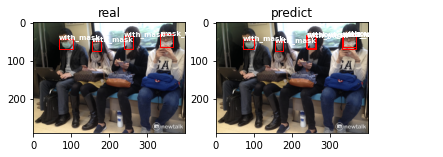

{'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
        [112.,  51., 120.,  68.],
        [155.,  60., 177.,  83.],
        [189.,  59., 210.,  80.],
        [235.,  57., 257.,  78.],
        [289.,  60., 309.,  83.],
        [313.,  68., 333.,  90.],
        [351.,  35., 364.,  59.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([3])}


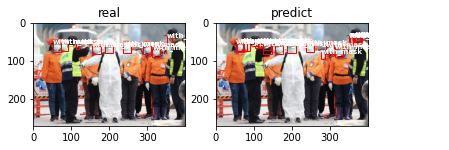

{'boxes': tensor([[ 70., 185., 176., 321.]]), 'labels': tensor([1]), 'image_id': tensor([4])}


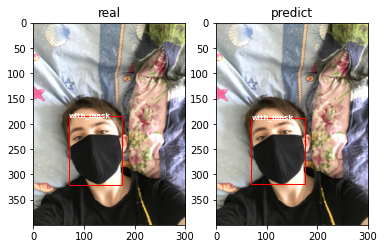

{'boxes': tensor([[118.,  54., 161.,  96.],
        [364.,  30., 401.,  66.],
        [192., 106., 229., 144.],
        [249.,  95., 291., 139.]]), 'labels': tensor([1, 3, 3, 1]), 'image_id': tensor([5])}


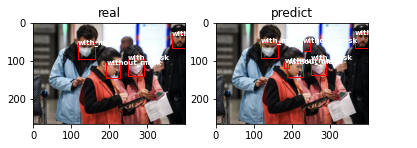

{'boxes': tensor([[254., 100., 387., 260.]]), 'labels': tensor([1]), 'image_id': tensor([6])}


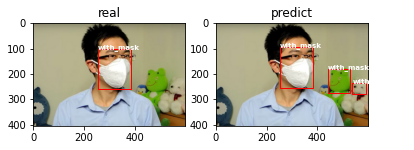

{'boxes': tensor([[253., 116., 342., 210.],
        [152.,  96., 222., 174.],
        [120., 134., 173., 194.],
        [118.,  66., 135.,  90.]]), 'labels': tensor([1, 1, 1, 3]), 'image_id': tensor([7])}


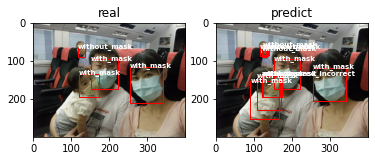

{'boxes': tensor([[ 75., 271., 152., 385.]]), 'labels': tensor([1]), 'image_id': tensor([8])}


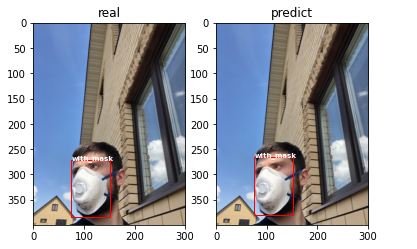

{'boxes': tensor([[148.,  75., 201., 133.],
        [ 27.,  78.,  56., 106.]]), 'labels': tensor([2, 3]), 'image_id': tensor([9])}


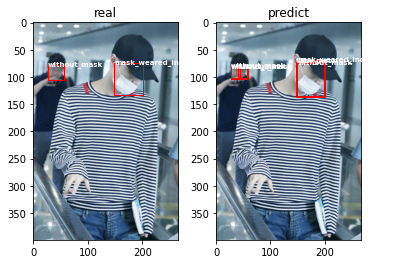

{'boxes': tensor([[ 98., 267., 194., 383.]]), 'labels': tensor([1]), 'image_id': tensor([10])}


In [14]:
def num_to_class(num):
    if num == 1:
        return 'with_mask'
    elif num == 2:
        return 'mask_weared_incorrect'
    elif num == 3:
        return 'without_mask'
    else:
        return 'unknown'

def plot_img(img, predict, annotation) :
    fig, ax = plt.subplots(1, 2)
    img = img.cpu().data
    predict['boxes'] = predict['boxes'].cpu().data
    predict['labels'] = predict['labels'].cpu().data
    annotation['boxes'] = annotation['boxes'].cpu().data
    annotation['lables'] = annotation['labels'].cpu().data
    
    ax[0].imshow(img.permute(1, 2, 0)) #rgb, w, h => w, h, rgb
    ax[1].imshow(img.permute(1, 2, 0))
    ax[0].set_title("real")
    ax[1].set_title("predict")
    
    for idx, box in enumerate(annotation["boxes"]) :
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(xmin, ymin, num_to_class(annotation["labels"][idx]), fontsize=7, color='white', weight='bold')
        
    for idx, box in enumerate(predict["boxes"]) :
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(xmin, ymin, num_to_class(predict["labels"][idx]), fontsize=7, color='white', weight='bold')

    plt.show()

model.eval()

with torch.no_grad() :
    for idx, (imgs, annotations) in enumerate(val_dataloader):
        if idx == 10 :
            break

        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
        preds = model(imgs)

        plot_img(imgs[0], preds[0], annotations[0])